# **DetectGPT for dummies**: Identifying AI-generated text
This notebook implements the **DetectGPT** method from Mitchell et al. (2023) [1], which helps determine whether a given text is AI-generated. The approach involves perturbing the text and analyzing its log-probabilities.

In [1]:
import os
import re
import json
import torch
import random
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import Dataset
from IPython.display import display

/workspace/.miniconda3/envs/detect_gpt_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## I- **Model setup**

This part is a simple setup of different transformer based models that will be needed to:
1. produce the AI-generated text - ``generation_model``
2. compute the log-probablities - ``computation_model``
3. perturb the text with the T5 perturbation - ``t5_model``

### 1. **Text generation**

In [3]:
CACHE_DIR = "/tmp/huggingface"

GENERATION_MODEL_NAME = "openai-community/gpt2"
# Model list (all tested)

# openai-community/gpt2
# openai-community/gpt2-medium
# openai-community/gpt2-large
# openai-community/gpt2-xl

# EleutherAI/gpt-neo-2.7B
# EleutherAI/gpt-j-6B
# EleutherAI/gpt-neox-20b

generation_model_kwargs = {}
if 'gpt-j' in GENERATION_MODEL_NAME or 'neox' in GENERATION_MODEL_NAME:
    generation_model_kwargs.update(dict(torch_dtype=torch.float16))
if 'gpt-j' in GENERATION_MODEL_NAME:
    generation_model_kwargs.update(dict(revision='float16'))

# Load model
generation_model = AutoModelForCausalLM.from_pretrained(GENERATION_MODEL_NAME, **generation_model_kwargs, cache_dir=CACHE_DIR)

# Load tokenizer
generation_tokenizer = AutoTokenizer.from_pretrained(GENERATION_MODEL_NAME, cache_dir=CACHE_DIR)

generation_tokenizer.model_max_length = 1024 # what is the impact for generation ??

if generation_tokenizer.pad_token is None:
    generation_tokenizer.pad_token = generation_tokenizer.eos_token
generation_tokenizer.pad_token_id = generation_tokenizer.eos_token_id

### 2. **Computation**

In [4]:
CACHE_DIR = "/tmp/huggingface"
COMPUTATION_MODEL_NAME = "EleutherAI/gpt-j-6B"
# Model list (all tested)

# openai-community/gpt2
# openai-community/gpt2-medium
# openai-community/gpt2-large
# openai-community/gpt2-xl

# EleutherAI/gpt-neo-2.7B
# EleutherAI/gpt-j-6B
# EleutherAI/gpt-neox-20b

computation_model_kwargs = {}
if 'gpt-j' in COMPUTATION_MODEL_NAME or 'neox' in COMPUTATION_MODEL_NAME:
    computation_model_kwargs.update(dict(torch_dtype=torch.float16))
if 'gpt-j' in COMPUTATION_MODEL_NAME:
    computation_model_kwargs.update(dict(revision='float16'))

# Load model
computation_model = AutoModelForCausalLM.from_pretrained(COMPUTATION_MODEL_NAME, **computation_model_kwargs, cache_dir=CACHE_DIR)

# Load tokenizer 
computation_tokenizer = AutoTokenizer.from_pretrained(COMPUTATION_MODEL_NAME, cache_dir=CACHE_DIR)

computation_tokenizer.model_max_length = 1024 

if computation_tokenizer.pad_token is None:
    computation_tokenizer.pad_token = computation_tokenizer.eos_token
computation_tokenizer.pad_token_id = computation_tokenizer.eos_token_id

computation_model.to(DEVICE)
print(DEVICE)

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

cuda


### 3. **Perturbation**

In [5]:
CACHE_DIR = "/tmp/huggingface"
PERTURBATION_MODEL_NAME = "google-t5/t5-3b"
# Model list (all tested)

# google-t5/t5-large - used for the experiment assessing impact of n_perturbations
# google-t5/t5-3b - general case use
# google-t5/t5-11b - use for gpt-neox or gpt3

TORCH_DTYPE = torch.bfloat16

# Load model
t5_model = AutoModelForSeq2SeqLM.from_pretrained(PERTURBATION_MODEL_NAME, torch_dtype=TORCH_DTYPE, cache_dir=CACHE_DIR)

# Load tokenizer 
t5_tokenizer = AutoTokenizer.from_pretrained(PERTURBATION_MODEL_NAME, cache_dir=CACHE_DIR)

t5_tokenizer.model_max_length = 512 

t5_model.to(DEVICE)
print(DEVICE)

cuda


## II- **Code setup**

### 1. **🔀 Text perturbation** *NEW VERSION*

This section defines the **T5-based perturbation function**, which modifies the input text slightly while preserving its meaning. 

- **Why is perturbation needed?** AI-generated text often sits in **low-curvature** probability regions, meaning slight perturbations can significantly change their log probabilities
- **How does it work?** The **T5 model** introduces variations to the text and helps in detecting AI-generated content

These perturbed texts will later be compared to their original versions to compute the discrepancy scores d.

In [6]:
def tokenize_and_mask(text: str, span_length: int, pct: float, buffer_size: int, ceil_pct: bool = False) -> str:
    """
    Tokenizes a text and applies masking by replacing certain spans with placeholder tokens

    Args:
        text (str): input text to be tokenized and masked
        span_length (int): length of each masked span
        pct (float): percentage of the text to be masked (as in DetectGPT codebase, so not exactly pure percentage of the text)
        buffer_size (int): buffer size around masked spans (to prevent overlap)
        ceil_pct (bool - optional): whether to round up the number of spans (Default: False)

    Return:
        text (str): masked text with placeholder token
    """
    tokens = text.split(' ')
    mask_string = '<<<mask>>>'

    # Calculate number of masked spans
    n_spans = pct * len(tokens) / (span_length + buffer_size * 2)

    if ceil_pct:
        n_spans = np.ceil(n_spans)
    n_spans = int(n_spans)

    n_masks = 0
    while n_masks < n_spans:
        start = np.random.randint(0, len(tokens) - span_length)
        end = start + int(span_length)
        search_start = max(0, start - buffer_size)
        search_end = min(len(tokens), end + buffer_size)

        # Ensure no overlapping masks in buffer region
        if mask_string not in tokens[search_start:search_end]:
            tokens[start:end] = [mask_string]
            n_masks += 1
    
    # Replace each occurrence of mask_string with <extra_id_NUM>, where NUM increments
    num_filled = 0
    for idx, token in enumerate(tokens):
        if token == mask_string:
            tokens[idx] = f'<extra_id_{num_filled}>'
            num_filled += 1

    assert num_filled == n_masks, f"num_filled {num_filled} != n_masks {n_masks}"

    text = ' '.join(tokens)
    return text

def count_masks(texts: list[str]) -> list[int]:
    """
    Counts the number of mask tokens in each text

    Args:
        texts (list): list of texts containing mask tokens (format: "<extra_id_N>" where N is any int)

    Returns:
        n_masks (list): list where each element represents the number of mask tokens in the corresponding text
    """
    n_masks = [len([x for x in text.split() if x.startswith("<extra_id_")]) for text in texts]
    return n_masks

def replace_masks(texts: list[str]) -> list[str]:
    """
    Replaces masked spans in texts with generated text using a T5 model

    Args:
        texts (list): list of texts containing mask tokens (format: "<extra_id_N>" where N is any int)

    Returns:
        texts_replaced (list): list of texts where masked spans have been replaced with generated content
    """
    n_expected = count_masks(texts) # Count number of masks per text
    stop_id = t5_tokenizer.encode(f"<extra_id_{max(n_expected)}>")[0] # Define stopping condition

    # Tokenize the input texts
    tokens = t5_tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(DEVICE)
    
    # Generate replacements for the masks using T5
    outputs = t5_model.generate(
        **tokens, 
        max_length=150, 
        do_sample=True, 
        top_p=1, 
        num_return_sequences=1, 
        eos_token_id=stop_id
    )

    # Decode the generated output
    texts_replaced = t5_tokenizer.batch_decode(outputs, skip_special_tokens=False)
    return texts_replaced

# Define a regex pattern to match all placeholder tokens in the format <extra_id_N> (where N is any int)
pattern = re.compile(r"<extra_id_\d+>")

def extract_fills(texts: list[str]) -> list[list[str]]:
    """
    Extracts the generated text fills from masked texts

    Args:
        texts (list): list of texts where masked spans have been replaced with generated text

    Returns:
        extracted_fills (list): a list of lists, where each inner list contains the extracted fills for the corresponding input text
    """
    # Remove "<pad>" and "</s>" tokens from the beginning/end of each text
    texts = [x.replace("<pad>", "").replace("</s>", "").strip() for x in texts]

    # Extract the text between mask tokens (pattern should be defined elsewhere)
    extracted_fills = [pattern.split(x)[1:-1] for x in texts]

    # Trim whitespace from each extracted fill
    extracted_fills = [[y.strip() for y in x] for x in extracted_fills]

    return extracted_fills

def apply_extracted_fills(masked_texts: list[str], extracted_fills: list[list[str]]) -> list[str]:
    """
    Replaces mask tokens in masked texts with corresponding extracted fills

    Args:
        masked_texts (list): list of texts containing mask tokens
        extracted_fills (list): list of lists, where each inner list contains the extracted fill text for the corresponding masked text

    Returns:
        texts (list): list of texts with all masks replaced by their corresponding extracted fills
    """
    # Split masked text into tokens, keeping spaces intact
    tokens = [x.split(' ') for x in masked_texts]

    # Count expected number of masks per text
    n_expected = count_masks(masked_texts)

    # Replace each mask token with the corresponding extracted fill
    for idx, (text, fills, n) in enumerate(zip(tokens, extracted_fills, n_expected)):
        if len(fills) < n:
            tokens[idx] = [] # Empty text if not enough fills are available
        else:
            for fill_idx in range(n):
                if f"<extra_id_{fill_idx}>" in text:
                    text[text.index(f"<extra_id_{fill_idx}>")] = fills[fill_idx]

    # Join tokens back into text format
    texts = [" ".join(x) for x in tokens]
    return texts

def perturb_texts_(texts: list[str], span_length: int, pct: float, buffer_size: int, ceil_pct: bool = False) -> list[str]:
    """
    Applies T5-based perturbation to a list of texts by masking spans, generating replacements,and applying the generated fills

    Args:
        texts (list): list of input texts to be perturbed
        span_length (int): length of each masked span
        pct (float): percentage of the text to be masked (as in DetectGPT codebase, so not exactly pure percentage of the text)
        buffer_size (int): buffer size around masked spans (to prevent overlap)
        ceil_pct (bool, optional): whether to round up the number of spans (Default: False)

    Returns:
        perturbed_texts (list): list of perturbed texts
    """
    # Step 1: Mask spans in the input texts
    masked_texts = [tokenize_and_mask(x, span_length, pct, buffer_size, ceil_pct) for x in texts]
    # print(f"Masked texts: {masked_texts}")

    # Step 2: Generate replacement texts
    raw_fills = replace_masks(masked_texts)
    # print(f"Raw fills: {raw_fills}")

    # Step 3: Extract only the generated fills
    extracted_fills = extract_fills(raw_fills)
    # print(f"Extracted fills: {extracted_fills}")

    # Step 4: Apply the extracted fills to reconstruct the perturbed texts
    perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)
    # print(f"Perturbed texts: {perturbed_texts}")
    # print(f"Original texts: {texts}")

    # Handle cases where the model doesn't generate the correct number of fills
    attempts = 1
    max_attempts = 20
    while '' in perturbed_texts and attempts <= max_attempts:
        idxs = [idx for idx, x in enumerate(perturbed_texts) if x == '']
        print(f'WARNING: {len(idxs)} texts have no fills. Retrying [attempt {attempts}].')

        # Retry perturbation for failed cases
        masked_texts = [tokenize_and_mask(texts[idx], span_length, pct, buffer_size, ceil_pct) for idx in idxs]
        raw_fills = replace_masks(masked_texts)
        extracted_fills = extract_fills(raw_fills)
        new_perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)

        # Update perturbed texts
        for idx, new_text in zip(idxs, new_perturbed_texts):
            perturbed_texts[idx] = new_text

        attempts += 1

    return perturbed_texts

def perturb_texts(texts: list[str], batch_size: int, span_length: int, pct: float, buffer_size: int, ceil_pct: bool = False) -> list[str]:
    """
    Applies T5-based perturbation to a list of texts (in chunks for efficiency)

    Note: wrapper function around `perturb_texts_`

    Args:
        texts (list): list of input texts to be perturbed
        span_length (int): length of each masked span
        pct (float): percentage of the text to be masked (as in DetectGPT codebase, so not exactly pure percentage of the text)
        buffer_size (int): buffer size around masked spans (to prevent overlap)
        ceil_pct (bool, optional): whether to round up the number of spans (Default: False)

    Returns:
        outputs (list): list of perturbed texts
    """
    outputs = []

    for i in range(0, len(texts), batch_size): # Process texts in batches of for efficiency
        batch = texts[i:i + batch_size]
        perturbed_batch = perturb_texts_(batch, span_length, pct, buffer_size, ceil_pct=ceil_pct)
        outputs.extend(perturbed_batch)

    return outputs

### 2. **🔍 Main functions: *DetectGPT* Method**

This section implements the **DetectGPT method**.

- **Key idea:** once again, AI-generated texts often **reside in low-curvature probability regions**.
- **How does it work?**
  - We perturb the text multiple times (``num_perturbation``). We will use ``n_samples`` texts with ``max_length`` words.
  - Compute log probabilities for both **original** and **perturbed** texts
  - Measure the **discrepancy score** (a higher score suggests AI-generated text)

In [7]:
def get_ll(text):
    with torch.no_grad():
        tokenized = computation_tokenizer(text, return_tensors="pt", truncation=True, max_length=1024).to(DEVICE)
        labels = tokenized.input_ids
        output = computation_model(**tokenized, labels=labels)
        avg_ll = -output.loss.item() # Loss is already averaged over tokens
    return avg_ll

def get_lls(texts):
    return [get_ll(text) for text in texts]

In [8]:
def get_ppl(text):
    with torch.no_grad():
        tokenized = computation_tokenizer(text, return_tensors="pt", truncation=True, max_length=1024).to(DEVICE)
        labels = tokenized.input_ids
        loss = computation_model(**tokenized, labels=labels).loss.item() 
    return float(np.exp(loss))

def get_ppls(texts):
    return [get_ppl(text) for text in texts]

In [ ]:
def compute_detectgpt_discrepancy(log_probs_per_text_base: list,
                                log_probs_per_text_transformed: list,
                                normalization: bool=False) -> list:
    """
    Compute the DetectGPT discrepancy metric for each of the n_samples texts. Computed for n_perturbations perturbations.

    Args:
        log_probs_per_text_base (list): original log probability of each text
        log_probs_per_text_transformed (list): list of size n_samples where each element is a list of the n_perturbations perturbed log probs
        normalization (bool): True if you want to normalize the discrepancy scores, False otherwise

    Returns:
        discrepancy_scores (list): list of discrepancy values (d) for the n_samples texts
    """
    n_samples = len(log_probs_per_text_base) 
    discrepancy_scores = []

    for i in range(n_samples):
        original_log_prob = log_probs_per_text_base[i]
        perturbed_log_probs = log_probs_per_text_transformed[i] # List of perturbed log probs

        # Compute mean log probability of the perturbed texts
        mu = np.mean(perturbed_log_probs)  

        # Compute discrepancy
        discrepancy_score_unormalized = original_log_prob - mu
        if normalization:
            # Normalize
            sigma = np.std(perturbed_log_probs)
            discrepancy_score_normalized = discrepancy_score_unormalized / sigma if sigma > 0 else discrepancy_score_unormalized
            discrepancy_scores.append(discrepancy_score_normalized)
        else:
            discrepancy_scores.append(discrepancy_score_unormalized)
    
    return discrepancy_scores

In [10]:
def optimized_processing(data: list, 
                         n_samples: int,
                         batch_size: int, 
                         max_length: int, 
                         n_perturbations: int, 
                         span_length: int, 
                         pct: float, 
                         buffer_size: int)-> tuple[list, list]:
    """
    Compute log probabilities for original and perturbed texts.
    
    This function processes multiple text samples, computes their log probabilities, 
    applies perturbations to the texts, and then computes the log probabilities 
    of the perturbed versions.

    Args:
        data (list): list of dictionaries containing text (e.g. [{"text": "sample text"}, ...])
        n_samples (int): number of texts to process
        batch_size (int): batch to group and proceed the perturbations (code speed up)
        max_length (int): maximum number of words to consider in each text
        n_perturbations (int): number of perturbations applied to each text
        span_length (int): length of each masked span
        pct (float): percentage of the text to be masked (as in DetectGPT codebase, so not exactly pure percentage of the text)
        buffer_size (int): buffer size around masked spans (to prevent overlap)
    
    Returns:
        tuple: 
            - log_probs_per_text_base (list): log probs of the original texts
            - log_probs_per_text_transformed (list of lists): log probs of the perturbed texts,
              structured as a list where each element corresponds to a text and contains 
              a list of its perturbed log probs
    """
    log_probs_per_text_transformed = []

    # Process original texts in batches
    original_texts = [" ".join(data[j]["text"].split()[:max_length]) for j in range(n_samples)]

    # Calculate log probabilities of the original texts
    log_probs_per_text_base = get_lls(texts=original_texts)

    for perturbation_idx in tqdm(range(n_perturbations), desc=f"Processing {n_perturbations} perturbations for {n_samples} texts. Perturbation number"):
        # Apply perturbation
        all_perturbed_texts = perturb_texts(texts=original_texts,
                                            batch_size=batch_size,
                                            span_length=span_length,
                                            pct=pct,
                                            buffer_size=buffer_size,
                                            ceil_pct=False)
        
        # Calculate log probabilities of the perturbed texts
        all_log_probs = get_lls(texts=all_perturbed_texts)

        # Organize results
        for j in range(n_samples):
            if perturbation_idx == 0:
                log_probs_per_text_transformed.append([])
            log_probs_per_text_transformed[j].append(all_log_probs[j])

    return log_probs_per_text_base, log_probs_per_text_transformed

In [11]:
# Alternative to optimized_processing function that allows you to save down the perturbed texts

def gen_perturbed(data: list,
                  n_samples: int=200,
                  max_length: int=200,
                  n_perturbations: int=100,
                  batch_size: int=128,
                  span_length: int=2,
                  pct: float=0.3,
                  buffer_size: int=1):
    """
    Generates pertubations for texts in data. 
    Returns list of length n_pertubations, each entry being a JSON object with perturbed text.
    Args:

    Returns:
        The output is a list of length n_pertubations, each entry being a list of length num_samples, 
        each entry being a string. The outer list is over the perturbations, the inner list is over the samples, 
        and the string is the perturbed text.
    
    """
    # Initialise list to store all perturbed JSON
    all_perturbed_texts = []
    
    # Process original texts in batches
    original_texts = [" ".join(data[j]["text"].split()[:max_length]) for j in range(n_samples)] # Truncate text to max_length, returns list of strings as before
    
    # Iterate for length num_pertubation
    for _ in tqdm(range(n_perturbations), desc=f"Processing {n_perturbations} perturbations for {n_samples} texts. Perturbation number"):

        # Randomly select 15% of text to mask, creates pertubations
        perturbed_texts = perturb_texts(texts=original_texts,
                                        batch_size=batch_size,
                                        span_length=span_length,
                                        pct=pct,
                                        buffer_size=buffer_size,
                                        ceil_pct=False
                                        )

        # Store in list
        all_perturbed_texts.append(perturbed_texts)
    
    return all_perturbed_texts

In [ ]:
def compare_log_prob(original_texts, all_perturbed_texts, n_perturbation=100):
    """
    Compares log probs of original text vs list of JSONs perturbed texts
    Args:

    Returns:
        log_probs_per_text_base is a list of length num_samples, each entry being the log prob of the corresponding original text
        log_probs_per_text_pert is a list of length num_samples, each entry being a list of length num_pertubations, each entry being the log prob of the corresponding perturbed text

    """
    list_original_texts = [" ".join(original_texts[j]["text"].split()) for j in range(len(original_texts))] # Truncate text to max_length, returns list of strings as before
    
    # Initialise list to store log prob of each perturbed JSON
    
    log_probs_per_text_pert = []

    # Get num_samples
    num_samples = len(list_original_texts)

    # Calculate log prob for original text in batch
    log_probs_per_text_base = get_lls(texts=list_original_texts)

    # Iterate 
    for perturbation_idx in tqdm(range(n_perturbation)):

        # Get the JSON file
        perturbed_texts = all_perturbed_texts[perturbation_idx]

        # Calculate log prob
        log_probs_per_text_tran = get_lls(texts=perturbed_texts)

        # Organize results by original text
        for j in range(num_samples):
            if perturbation_idx == 0:
                log_probs_per_text_pert.append([])
            log_probs_per_text_pert[j].append(log_probs_per_text_tran[j])
        
    return log_probs_per_text_base, log_probs_per_text_pert

### 3. **Utility functions**

In [13]:
# Memory management utilities
def clear_cuda_cache():
    """Clear CUDA cache to free up memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

## III- **Data loading**

**📌 Dataset format guidelines**

All datasets (human-written and AI-generated) must follow this format:

- Stored as a **`.jsonl`** where each line is a dictionary.
- Each entry contains (minimum requirement):
  - `"text"`: the text content
  - `"model"`: for human text please label it as `"human"` and for AI-generated texts, please specify the model used (e.g. ``"gpt2-large"``)
  - `"source"`: the origin of the text (e.g., `"wikihow"`, `"reddit"`, `"news articles"`)

#### Exemple (as in ``subtaskB_train.jsonl`` located in `Datasets\SemEval2024-Task8`):
```json
{"text": "A groundbreaking discovery in physics was made today.", "model": "human", "source": "news articles"}
{"text": "The AI revolution is shaping the future of work.", "model": "chatGPT", "source": "AI Generated"}


### 1. **Human texts**

In [14]:
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# FILE_RELATIVE_PATH = "Datasets\SemEval2024-Task8\subtaskB_train.jsonl"
# FILE_PATH = os.path.join(BASE_DIR,FILE_RELATIVE_PATH) 

# if not os.path.exists(FILE_PATH):
#     raise FileNotFoundError(f"File not found: {FILE_PATH}")

# data_human = []

# # Efficiently process the file line by line
# with open(FILE_PATH, "r", encoding="utf-8") as file:
#     for line in file:
#         record = json.loads(line)  # Parse JSON once
#         if record.get("model") == "human":
#             data_human.append(record)

# # Print first human record
# print("First human text record:", data_human[0] if data_human else "No human data found.")

In [15]:
# For XSUM dataset

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
FILE_RELATIVE_PATH = "Data/EdinburghNLP___xsum/default/1.2.0/40db7604fedb616a9d2b0673d11838fa5be8451c/xsum-test.arrow"  # CHANGE THIS TO THE PATH OF THE HUMAN-GENERATED TEXT FILE
# FILE_PATH = os.path.join(BASE_DIR,FILE_RELATIVE_PATH) 
FILE_PATH = FILE_RELATIVE_PATH

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}")


# For XSUM data - convert into a list of dictionaries
# Load dataset using Hugging Face's datasets library
dataset = Dataset.from_file(FILE_PATH)
# Keep only the first 200 rows
sample_size_original = 200   # CHANGE THIS TO CONTROL THE NUMBER OF DATAPOINTS TO USE
dataset = dataset.select(range(sample_size_original))

# Convert to Pandas DataFrame
df = dataset.to_pandas()
# Adapt the dataframe to the desired style
df = df.rename(columns={"document": "text"}).drop(columns=["summary"])  # Rename and drop columns
df["model"] = "human"   # Add a new column to track that all these documents are human-generated

# Truncate text to MAX_LENGTH_ORIGINAL tokens
MAX_LENGTH_ORIGINAL = 200    # CHANGE THIS TO CONTROL THE MAXIMUM NUMBER OF TOKENS TO USE
df["text"] = df["text"].apply(lambda x: generation_tokenizer.convert_tokens_to_string(generation_tokenizer.tokenize(x)[:MAX_LENGTH_ORIGINAL]) if len(generation_tokenizer.tokenize(x)) > MAX_LENGTH_ORIGINAL else x)

# Convert to list of dictionaries
data_human = df.to_dict(orient="records")

Token indices sequence length is longer than the specified maximum sequence length for this model (1325 > 1024). Running this sequence through the model will result in indexing errors


### 2. **AI-generated texts**

#### 2.1. *Option 1: produce own AI-generated texts*

In [16]:
def generate_text(prompt: str, max_length: int) -> str:
    """
    Generate AI text from a given prompt

    Args:
        prompt (str): prompt to generate text
        max_length (int): max length of generated text

    Returns:
        cleaned_text (str): cleaned generated text
    """
    inputs = generation_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(DEVICE)
    
    with torch.no_grad():
        output = generation_model.generate(**inputs, max_length=max_length, do_sample=True, temperature=1.0)    # CHANGE THE GENERATION MODEL TEMPERATURE HERE (originally 0.7)
        # extra arguemnts to think about: 
        # min_length=150
        # max_length=200
        # top_p=0.96
        # top_k=40
        # pad_token_id=generation_model.eos_token_id
        # eos_token_id=generation_model.eos_token_id
        
    generated_text = generation_tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_text
    # The output is a string of the generated text


def generate_prompt(prompt_list: list) -> list:
    """
    Truncate the 'text' field in each dictionary to the first 30 tokens.

    Args:
        prompt_list (list): List of dictionaries with keys 'text', 'id', and 'model'.

    Returns:
        list: Updated list with truncated 'text' values.
    """
    truncated_prompts = []
    for entry in prompt_list:
        tokens = generation_tokenizer.tokenize(entry['text'])
        truncated_text = generation_tokenizer.convert_tokens_to_string(tokens[:30]) # CHANGE THIS TO CONTROL THE NUMBER OF TOKENS THE GENERATION MODEL IS GIVEN AS A PROMPT
        truncated_prompts.append({
            "text": truncated_text,
            "id": entry["id"],
            "model": entry["model"]
        })
    return truncated_prompts
    # The output is a list of dictionaries with keys 'text', 'id', and 'model'


def generate_dataset(prompt_list: list, max_length: int, generation_model_name: str) -> list:
    """
    Generates a dataset of AI-generated texts based on the given original prompt list.

    Args:
        prompt_list (list): Original list of dictionaries with full 'text'.
        max_length (int): Maximum length of each generated text.

    Returns:
        list: Dataset of AI-generated texts (list of dictionaries).
    """
    truncated_prompts = generate_prompt(prompt_list)  # Apply generate_prompt within generate_dataset

    data_ai = [
        {
            "text": generate_text(entry["text"], max_length),
            "id": entry["id"],
            "model": generation_model_name
        }
        for entry in truncated_prompts
    ]
    return data_ai
    # The output is a list of dictionaries, each dictionary has keys 'text', 'id', and 'model'

In [17]:
generation_model.to(DEVICE)
print(DEVICE)

clear_cuda_cache()
data_ai_generated = generate_dataset(data_human, MAX_LENGTH_ORIGINAL, GENERATION_MODEL_NAME)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


cuda


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [18]:
# Function to save the AI-generated dataset in the correct .jsonl format

def save_ai_dataset_jsonl(data, file_name_base, generation_model_name, sample_size, max_length):
    """
    Saves a dataset in JSONL format in a structured directory.
    
    Parameters:
        data (list): List of dictionaries to be saved.
        file_name_base (str): Base name for the file.
    """
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"{file_name_base}__Generated_By_{generation_model_name}__{sample_size}_Samples__{max_length}_Max_Length__{timestamp}.jsonl"   # CHANGE THIS TO CONTROL THE FORMAT OF THE FILE NAME
    file_relative_path = os.path.join("Data", "AI-Generated", file_name)
    # file_path = os.path.join(BASE_DIR, file_relative_path)
    file_path = file_relative_path
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Save the dataset in JSONL format
    with open(file_path, "w", encoding="utf-8") as f:
        for entry in data:
            f.write(json.dumps(entry) + "\n")
    
    print(f"Dataset saved at: {file_path}")

In [19]:
# Save and check the AI-generated dataset

# Save the AI-generated dataset
save_ai_dataset_jsonl(data_ai_generated, "XSUM", GENERATION_MODEL_NAME, sample_size_original, MAX_LENGTH_ORIGINAL) # CHANGE THIS TO CONTROL THE FILE NAME

# Print first AI-generated text record
print("First AI-generated text record:", data_ai_generated[0] if data_ai_generated else "No AI-generated data found.")

Dataset saved at: Data/AI-Generated/XSUM__Generated_By_openai-community/gpt2__200_Samples__200_Max_Length__20250319_095459.jsonl
First AI-generated text record: {'text': 'Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year.\n\nMr Morrison said he had tried every treatment plan available to him for 10 years and found the only work available to him was a counselling counsellor.\n\nHe said he did have his own counselling centre, but no formal training.\n\n"I only had that counsellor in my day," he said.\n\n"The counsellor kept me from the pain of my heart. He did give me an opportunity to help that person with the most important issues that come with having a job."', 'id': '38264402', 'model': 'openai-community/gpt2'}


#### 2.2. *Option 2: load AI-generated texts from a dataset*

In [20]:
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# FILE_RELATIVE_PATH = "Datasets\SemEval2024-Task8\subtaskB_train.jsonl"
# # FILE_RELATIVE_PATH = "Datasets\AI-generated\dataset_ai.jsonl"
# FILE_PATH = os.path.join(BASE_DIR,FILE_RELATIVE_PATH) 

# if not os.path.exists(FILE_PATH):
#     raise FileNotFoundError(f"File not found: {FILE_PATH}")

# data_ai_dataset = []

# # Read entire file and parse as JSON list
# with open(FILE_PATH, "r", encoding="utf-8") as file:
#     for line in file:
#         record = json.loads(line)  # Parse JSON once
#         if record.get("model") != "human":
#             data_ai_dataset.append(record)

# # Print first AI-generated text record
# print("First AI-generated text record:", data_ai_dataset[0] if data_ai_dataset else "No AI-generated data found.")

### 3. **Texts perplexity**

In [21]:
# DATA = data_human
# n_samples = 2
# max_length = 10

# original_texts = [" ".join(DATA[j]["text"].split()[:max_length]) for j in range(n_samples)]

# clear_cuda_cache()
# perplexity_scores = get_ppls(texts=original_texts)

## IV- **Exemple usage**

In [22]:
# Function to save the perturbations in the correct .jsonl format

def save_perturbations_jsonl(all_perturbed_texts, file_name_base, n_samples, max_length, n_perturbations, generation_model_name, perturbation_model_name):
    """
    Saves perturbed texts in JSONL format, where each line is a list of perturbed texts (one perturbation batch).

    Parameters:
        all_perturbed_texts (list of lists): List of lists containing perturbed texts.
        file_name_base (str): Base name for the file.
        generation_model_name (str): Name of the model that generated the original texts.
        perturbation_model_name (str): Name of the model that generated the perturbations.
    """
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = (
    f"{file_name_base}__{n_samples}_Samples__{max_length}_Max_Length__"
    f"{n_perturbations}_Perturbations__Generated_By_{generation_model_name}__"
    f"Perturbed_By_{perturbation_model_name}__{timestamp}.jsonl"
    )  # CHANGE THIS TO CONTROL THE FORMAT OF THE FILE NAME
    file_relative_path = os.path.join("Data", "Perturbations", file_name)
    # file_path = os.path.join(BASE_DIR, file_relative_path)
    file_path = file_relative_path
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Save the dataset in JSONL format
    with open(file_path, "w", encoding="utf-8") as f:
        for perturbed_texts in all_perturbed_texts:
            f.write(json.dumps(perturbed_texts) + "\n")
    
    print(f"Dataset saved at: {file_path}")

In [23]:
# Function to save the results in the correct .jsonl format

def save_results_jsonl(data, file_name_base, n_samples, max_length, n_perturbations, generation_model_name, perturbation_model_name, computation_model_name):
    """
    Saves a dataset in JSONL format in a structured directory.
    
    Parameters:
        data (list): List of results to be saved.
        file_name_base (str): Base name for the file.
    """
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = (
    f"{file_name_base}__{n_samples}_Samples__{max_length}_Max_Length__"
    f"{n_perturbations}_Perturbations__Generated_By_{generation_model_name}__"
    f"Perturbed_By_{perturbation_model_name}__Scored_By_{computation_model_name}__"
    f"{timestamp}.jsonl"
    )  # CHANGE THIS TO CONTROL THE FORMAT OF THE FILE NAME
    file_relative_path = os.path.join("Results", file_name)
    # file_path = os.path.join(BASE_DIR, file_relative_path)
    file_path = file_relative_path
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Save the dataset in JSONL format
    with open(file_path, "w") as f:
        json.dump(data, f, indent=2)
    
    print(f"Dataset saved at: {file_path}")

Human texts

In [24]:
# Data
DATA = data_human

# Experiment setup
NUM_SAMPLES = sample_size_original
MAX_LENGTH = MAX_LENGTH_ORIGINAL

# Perturbation setup
NUM_PERTURBATIONS = 100
BATCH_SIZE = 20
SPAN_LENGTH = 2
PCT = 0.3
BUFFER_SIZE = 1

clear_cuda_cache()

# # Compute log probs before and after perturbation
# log_probs_base_human, log_probs_transformed_human = optimized_processing(
#     data=DATA,
#     n_samples=n_samples,
#     max_length=max_length,
#     n_perturbations=n_perturbations,
#     span_length=span_length,
#     pct=pct,
#     buffer_size=buffer_size
#     )

perturbed_texts_human = gen_perturbed(DATA, NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, BATCH_SIZE, SPAN_LENGTH, PCT, BUFFER_SIZE)
save_perturbations_jsonl(perturbed_texts_human, "XSUM_Human", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, "Human", PERTURBATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

# TO USE IF YOU HAVE ALREADY PERTURBED THE HUMAN TEXT, AND RATHER THAN PERTURBING IT AGAIN, CAN JUST DOWNLOAD THE PREVIOUS RESULT
# # Path to your JSON file
# file_path =

# # Open and load the JSON file
# with open(file_path, "r") as f:
#     perturbed_texts_human = json.load(f)

# # Check the structure
# print(f"Total perturbations: {len(data)}")
# if data:
#     print(f"Samples per perturbation: {len(data[0])}")
#     print(f"First sample of the first perturbation: {data[0][0]}")

log_probs_base_human, log_probs_transformed_human = compare_log_prob(DATA, perturbed_texts_human, NUM_PERTURBATIONS)
discrepancy_scores_human = compute_detectgpt_discrepancy(log_probs_base_human, log_probs_transformed_human, normalization=True)

results_human = {}
results_human["log_probs_base"] = log_probs_base_human
results_human["log_probs_transformed"] = log_probs_transformed_human
results_human["discrepancy_scores"] = discrepancy_scores_human

Processing 100 perturbations for 200 texts. Perturbation number:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 100 perturbations for 200 texts. Perturbation number: 100%|██████████| 100/100 [34:10<00:00, 20.51s/it]


Dataset saved at: Data/Perturbations/XSUM_Human__200_Samples__200_Max_Length__100_Perturbations__Generated_By_Human__Perturbed_By_google-t5/t5-3b__20250319_102910.jsonl


100%|██████████| 100/100 [09:38<00:00,  5.79s/it]


In [25]:
# # Saving results
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# FILE_RELATIVE_PATH = "Results\experiment_0_results_human.json"
# FILE_PATH = os.path.join(BASE_DIR,FILE_RELATIVE_PATH) 
# with open(FILE_PATH, "w") as f:
#     json.dump(results_human, f, indent=2)

# Save the results

save_results_jsonl(results_human, "XSUM_Human", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, "Human", PERTURBATION_MODEL_NAME, COMPUTATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

Dataset saved at: Results/XSUM_Human__200_Samples__200_Max_Length__100_Perturbations__Generated_By_Human__Perturbed_By_google-t5/t5-3b__Scored_By_EleutherAI/gpt-j-6B__20250319_103854.jsonl


AI-generated texts

In [26]:
# Data
DATA = data_ai_generated

# Experiment setup
NUM_SAMPLES = sample_size_original
MAX_LENGTH = MAX_LENGTH_ORIGINAL

# Perturbation setup
NUM_PERTURBATIONS = 100
BATCH_SIZE = 20
SPAN_LENGTH = 2
PCT = 0.3
BUFFER_SIZE = 1

# # Compute log probs before and after perturbation
# clear_cuda_cache()
# log_probs_base_ai, log_probs_transformed_ai = optimized_processing(
#     data=DATA,
#     n_samples=n_samples,
#     max_length=max_length,
#     n_perturbations=n_perturbations,
#     span_length=span_length,
#     pct=pct,
#     buffer_size=buffer_size
#     )

perturbed_texts_ai = gen_perturbed(DATA, NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, BATCH_SIZE, SPAN_LENGTH, PCT, BUFFER_SIZE)
save_perturbations_jsonl(perturbed_texts_ai, "XSUM_AI", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, GENERATION_MODEL_NAME, PERTURBATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

log_probs_base_ai, log_probs_transformed_ai = compare_log_prob(DATA, perturbed_texts_ai, NUM_PERTURBATIONS)
discrepancy_scores_ai = compute_detectgpt_discrepancy(log_probs_base_ai, log_probs_transformed_ai, normalization=True)

results_ai = {}
results_ai["log_probs_base"] = log_probs_base_ai
results_ai["log_probs_transformed"] = log_probs_transformed_ai
results_ai["discrepancy_scores"] = discrepancy_scores_ai

Processing 100 perturbations for 200 texts. Perturbation number: 100%|██████████| 100/100 [36:53<00:00, 22.14s/it]


Dataset saved at: Data/Perturbations/XSUM_AI__200_Samples__200_Max_Length__100_Perturbations__Generated_By_openai-community/gpt2__Perturbed_By_google-t5/t5-3b__20250319_111548.jsonl


100%|██████████| 100/100 [09:36<00:00,  5.77s/it]


In [27]:
# # Saving results
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# FILE_RELATIVE_PATH = "Results\experiment_0_results_ai.json"
# FILE_PATH = os.path.join(BASE_DIR,FILE_RELATIVE_PATH) 

# with open(FILE_PATH, "w") as f:
#     json.dump(results_ai, f, indent=2)

# Save the results

save_results_jsonl(results_ai, "XSUM_AI", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, GENERATION_MODEL_NAME, PERTURBATION_MODEL_NAME, COMPUTATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

Dataset saved at: Results/XSUM_AI__200_Samples__200_Max_Length__100_Perturbations__Generated_By_openai-community/gpt2__Perturbed_By_google-t5/t5-3b__Scored_By_EleutherAI/gpt-j-6B__20250319_112531.jsonl


## V- **Analysis**

Sense-Checks

In [28]:
# Print the first perturbation of the first text of the AI-generated dataset
print("First perturbation of the first text of the AI-generated dataset:")
print(perturbed_texts_ai[0][0])
# Print the first perturbation of the second text of the AI-generated dataset
print("First perturbation of the second text of the AI-generated dataset:")
print(perturbed_texts_ai[2][1])

# Print the first perturbation of the first text of the human dataset
print("First perturbation of the first text of the human dataset:")
print(perturbed_texts_human[0][0])
# Print the first perturbation of the second text of the human dataset
print("First perturbation of the second text of the human dataset:")
print(perturbed_texts_human[2][1])

First perturbation of the first text of the AI-generated dataset:
Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year. Mr Morrison said he had tried every treatment plan available to him for 10 years and found the only work available to him was a counselling counsellor. He said he did have his own counselling centre, but no formal training. "I really do see myself as that counsellor in my day," he said. "He kept me from the pain of my heart. He did give me an opportunity to help that person with the most important issues that come with such a job."
First perturbation of the second text of the AI-generated dataset:
Officers searched properties in the Parkdale Park and Colonsay View areas of the city on Wednesday. Detectives said three firearms, ammunition and a semi-automatic handgun were located in a dumpster on an adjacent lot at 3500 South St. W. (Photo: Michael Short, The Journal News) Investigators say that two men fired at

### 1. **Histograms of the discrepancy scores**

In [29]:
NORMALIZATION = True # True if you want to normalize the discrepancy scores

In [30]:
# # AI texts results
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# FILE_RELATIVE_PATH = "Results\\results_ai.json"
# FILE_PATH = os.path.join(BASE_DIR,FILE_RELATIVE_PATH) 

# with open(FILE_PATH, 'r') as file:
#     data_ai = json.load(file)

In [31]:
# log_probs_base_ai = data_ai["log_probs_base"]
# log_probs_transformed_ai = data_ai["log_probs_transformed"]

# discrepancy_scores_ai = compute_detectgpt_discrepancy(log_probs_base_ai,log_probs_transformed_ai,normalization=NORMALIZATION)

In [32]:
# # Human texts results
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# FILE_RELATIVE_PATH = "Results\\results_human.json"
# FILE_PATH = os.path.join(BASE_DIR,FILE_RELATIVE_PATH) 

# with open(FILE_PATH, 'r') as file:
#     data_human = json.load(file)

In [33]:
# log_probs_base_human = data_human["log_probs_base"]
# log_probs_transformed_human = data_human["log_probs_transformed"]

# discrepancy_scores_human = compute_detectgpt_discrepancy(log_probs_base_human,log_probs_transformed_human,normalization=NORMALIZATION)

In [ ]:
def get_roc_metrics(discrepancy_scores_human, discrepancy_scores_ai):
    fpr, tpr, _ = roc_curve([0] * len(discrepancy_scores_human) + [1] * len(discrepancy_scores_ai), discrepancy_scores_human + discrepancy_scores_ai)
    roc_auc = auc(fpr, tpr)
    return fpr.tolist(), tpr.tolist(), float(roc_auc)

In [ ]:
fpr,tpr,roc_auc = get_roc_metrics(discrepancy_scores_human, discrepancy_scores_ai)
#fpr,tpr,roc_auc = get_roc_metrics(data_human['discrepancy_scores'], data_ai['discrepancy_scores'])
print(f"AUROC: {roc_auc:.3f}")

plt.hist(discrepancy_scores_human, bins='auto', alpha=0.5, label='Human', edgecolor='black')
plt.hist(discrepancy_scores_ai, bins='auto', alpha=0.5, label='AI', edgecolor='black')

plt.xlabel(f'Discrepancy scores (normalization={NORMALIZATION})')
plt.ylabel('Frequency')
plt.title(f'Computation model: {COMPUTATION_MODEL_NAME}')
plt.legend()
plt.show()

In [ ]:
def roc_curves(fpr,tpr):
    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({COMPUTATION_MODEL_NAME} - {PERTURBATION_MODEL_NAME})')

Optimal threshold: 0.58
AUROC: 0.82


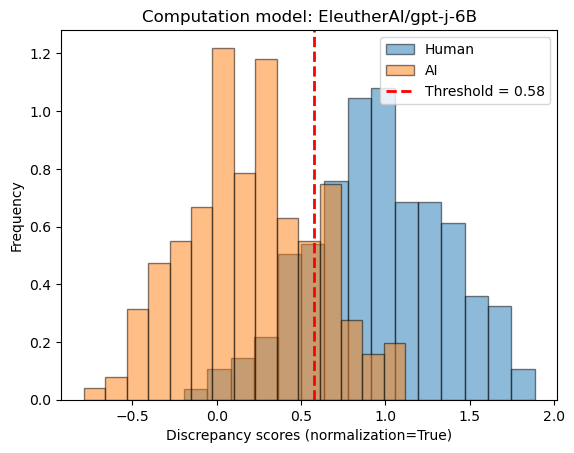

In [35]:
roc_curves(fpr,tpr)

## VI- **More Computations on Datasets**

Keeping the same human-generated and AI-generated texts, and the same perturbations of these, the following code runs the compare_log_prob and compute_detect_gpt_discrepancy on them using different computation models

### **Change Computation Model - GPT-Neo-2.7B**

In [36]:
CACHE_DIR = "/tmp/huggingface"
COMPUTATION_MODEL_NAME = "EleutherAI/gpt-neo-2.7B"
# Model list (all tested)

# openai-community/gpt2
# openai-community/gpt2-medium
# openai-community/gpt2-large
# openai-community/gpt2-xl

# EleutherAI/gpt-neo-2.7B
# EleutherAI/gpt-j-6B
# EleutherAI/gpt-neox-20b

computation_model_kwargs = {}
if 'gpt-j' in COMPUTATION_MODEL_NAME or 'neox' in COMPUTATION_MODEL_NAME:
    computation_model_kwargs.update(dict(torch_dtype=torch.float16))
if 'gpt-j' in COMPUTATION_MODEL_NAME:
    computation_model_kwargs.update(dict(revision='float16'))

# Load model
computation_model = AutoModelForCausalLM.from_pretrained(COMPUTATION_MODEL_NAME, **computation_model_kwargs, cache_dir=CACHE_DIR)

# Load tokenizer 
computation_tokenizer = AutoTokenizer.from_pretrained(COMPUTATION_MODEL_NAME, cache_dir=CACHE_DIR)

computation_tokenizer.model_max_length = 1024 

if computation_tokenizer.pad_token is None:
    computation_tokenizer.pad_token = computation_tokenizer.eos_token
computation_tokenizer.pad_token_id = computation_tokenizer.eos_token_id

computation_model.to(DEVICE)
print(DEVICE)

cuda


### Re-Calculate Discrepancy for GPT-Neo-2.7B

Human Texts

In [37]:
# Data
DATA = data_human

# Experiment setup
NUM_SAMPLES = sample_size_original
MAX_LENGTH = MAX_LENGTH_ORIGINAL

clear_cuda_cache()

log_probs_base_human_2, log_probs_transformed_human_2 = compare_log_prob(DATA, perturbed_texts_human, NUM_PERTURBATIONS)
discrepancy_scores_human_2 = compute_detectgpt_discrepancy(log_probs_base_human_2, log_probs_transformed_human_2, normalization=True)

results_human_2 = {}
results_human_2["log_probs_base"] = log_probs_base_human_2
results_human_2["log_probs_transformed"] = log_probs_transformed_human_2
results_human_2["discrepancy_scores"] = discrepancy_scores_human_2

100%|██████████| 100/100 [18:08<00:00, 10.88s/it]


In [38]:
save_results_jsonl(results_human_2, "XSUM_Human", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, "Human", PERTURBATION_MODEL_NAME, COMPUTATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

Dataset saved at: Results/XSUM_Human__200_Samples__200_Max_Length__100_Perturbations__Generated_By_Human__Perturbed_By_google-t5/t5-3b__Scored_By_EleutherAI/gpt-neo-2.7B__20250319_114542.jsonl


AI-Generated Texts

In [39]:
# Data
DATA = data_ai_generated

# Experiment setup
NUM_SAMPLES = sample_size_original
MAX_LENGTH = MAX_LENGTH_ORIGINAL

# Perturbation setup

# # Compute log probs before and after perturbation
# clear_cuda_cache()
# log_probs_base_ai, log_probs_transformed_ai = optimized_processing(
#     data=DATA,
#     n_samples=n_samples,
#     max_length=max_length,
#     n_perturbations=n_perturbations,
#     span_length=span_length,
#     pct=pct,
#     buffer_size=buffer_size
#     )

log_probs_base_ai_2, log_probs_transformed_ai_2 = compare_log_prob(DATA, perturbed_texts_ai, NUM_PERTURBATIONS)
discrepancy_scores_ai_2 = compute_detectgpt_discrepancy(log_probs_base_ai_2, log_probs_transformed_ai_2, normalization=True)

results_ai_2 = {}
results_ai_2["log_probs_base"] = log_probs_base_ai_2
results_ai_2["log_probs_transformed"] = log_probs_transformed_ai_2
results_ai_2["discrepancy_scores"] = discrepancy_scores_ai_2

100%|██████████| 100/100 [17:28<00:00, 10.48s/it]


In [40]:
save_results_jsonl(results_ai_2, "XSUM_AI", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, GENERATION_MODEL_NAME, PERTURBATION_MODEL_NAME, COMPUTATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

Dataset saved at: Results/XSUM_AI__200_Samples__200_Max_Length__100_Perturbations__Generated_By_openai-community/gpt2__Perturbed_By_google-t5/t5-3b__Scored_By_EleutherAI/gpt-neo-2.7B__20250319_120321.jsonl


### Histograms of the Discrepancy Scores and AUROC for GPT-Neo-2.7B

In [ ]:
fpr,tpr,roc_auc = get_roc_metrics(discrepancy_scores_human_2, discrepancy_scores_ai_2)
#fpr,tpr,roc_auc = get_roc_metrics(data_human['discrepancy_scores'], data_ai['discrepancy_scores'])
print(f"AUROC: {roc_auc:.3f}")

plt.hist(discrepancy_scores_human_2, bins='auto', alpha=0.5, label='Human', edgecolor='black')
plt.hist(discrepancy_scores_ai_2, bins='auto', alpha=0.5, label='AI', edgecolor='black')

plt.xlabel(f'Discrepancy scores (normalization={NORMALIZATION})')
plt.ylabel('Frequency')
plt.title(f'Computation model: {COMPUTATION_MODEL_NAME}')
plt.legend()
plt.show()

In [ ]:
def roc_curves(fpr,tpr):
    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({COMPUTATION_MODEL_NAME} - {PERTURBATION_MODEL_NAME})')

Optimal threshold: 0.49
AUROC: 0.67


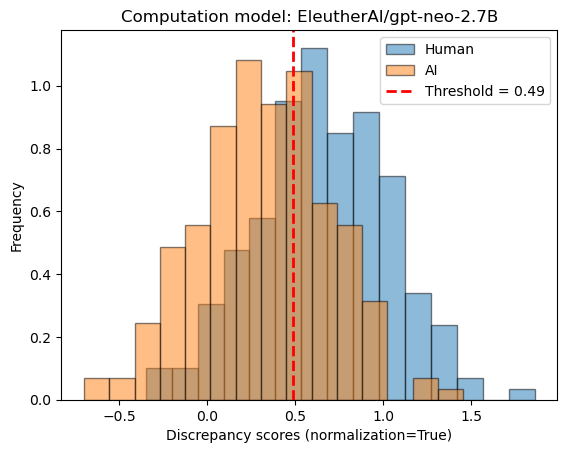

In [ ]:
roc_curves(fpr,tpr)

### **Change Computation Model - GPT2**

In [42]:
CACHE_DIR = "/tmp/huggingface"
COMPUTATION_MODEL_NAME = "openai-community/gpt2"
# Model list (all tested)

# openai-community/gpt2
# openai-community/gpt2-medium
# openai-community/gpt2-large
# openai-community/gpt2-xl

# EleutherAI/gpt-neo-2.7B
# EleutherAI/gpt-j-6B
# EleutherAI/gpt-neox-20b

computation_model_kwargs = {}
if 'gpt-j' in COMPUTATION_MODEL_NAME or 'neox' in COMPUTATION_MODEL_NAME:
    computation_model_kwargs.update(dict(torch_dtype=torch.float16))
if 'gpt-j' in COMPUTATION_MODEL_NAME:
    computation_model_kwargs.update(dict(revision='float16'))

# Load model
computation_model = AutoModelForCausalLM.from_pretrained(COMPUTATION_MODEL_NAME, **computation_model_kwargs, cache_dir=CACHE_DIR)

# Load tokenizer 
computation_tokenizer = AutoTokenizer.from_pretrained(COMPUTATION_MODEL_NAME, cache_dir=CACHE_DIR)

computation_tokenizer.model_max_length = 1024 

if computation_tokenizer.pad_token is None:
    computation_tokenizer.pad_token = computation_tokenizer.eos_token
computation_tokenizer.pad_token_id = computation_tokenizer.eos_token_id

computation_model.to(DEVICE)
print(DEVICE)

cuda


### Re-Calculate Discrepancy for GPT2

Human Texts

In [43]:
# Data
DATA = data_human

# Experiment setup
NUM_SAMPLES = sample_size_original
MAX_LENGTH = MAX_LENGTH_ORIGINAL

clear_cuda_cache()

log_probs_base_human_3, log_probs_transformed_human_3 = compare_log_prob(DATA, perturbed_texts_human, NUM_PERTURBATIONS)
discrepancy_scores_human_3 = compute_detectgpt_discrepancy(log_probs_base_human_3, log_probs_transformed_human_3, normalization=True)

results_human_3 = {}
results_human_3["log_probs_base"] = log_probs_base_human_3
results_human_3["log_probs_transformed"] = log_probs_transformed_human_3
results_human_3["discrepancy_scores"] = discrepancy_scores_human_3

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [44]:
save_results_jsonl(results_human_3, "XSUM_Human", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, "Human", PERTURBATION_MODEL_NAME, COMPUTATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

Dataset saved at: Results/XSUM_Human__200_Samples__200_Max_Length__100_Perturbations__Generated_By_Human__Perturbed_By_google-t5/t5-3b__Scored_By_openai-community/gpt2__20250319_120520.jsonl


AI-Generated Texts

In [45]:
# Data
DATA = data_ai_generated

# Experiment setup
NUM_SAMPLES = sample_size_original
MAX_LENGTH = MAX_LENGTH_ORIGINAL

# # Compute log probs before and after perturbation
# clear_cuda_cache()
# log_probs_base_ai, log_probs_transformed_ai = optimized_processing(
#     data=DATA,
#     n_samples=n_samples,
#     max_length=max_length,
#     n_perturbations=n_perturbations,
#     span_length=span_length,
#     pct=pct,
#     buffer_size=buffer_size
#     )

log_probs_base_ai_3, log_probs_transformed_ai_3 = compare_log_prob(DATA, perturbed_texts_ai, NUM_PERTURBATIONS)
discrepancy_scores_ai_3 = compute_detectgpt_discrepancy(log_probs_base_ai_3, log_probs_transformed_ai_3, normalization=True)

results_ai_3 = {}
results_ai_3["log_probs_base"] = log_probs_base_ai_3
results_ai_3["log_probs_transformed"] = log_probs_transformed_ai_3
results_ai_3["discrepancy_scores"] = discrepancy_scores_ai_3

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


In [46]:
save_results_jsonl(results_ai_3, "XSUM_AI", NUM_SAMPLES, MAX_LENGTH, NUM_PERTURBATIONS, GENERATION_MODEL_NAME, PERTURBATION_MODEL_NAME, COMPUTATION_MODEL_NAME) # CHANGE THIS TO CONTROL THE FILE NAME

Dataset saved at: Results/XSUM_AI__200_Samples__200_Max_Length__100_Perturbations__Generated_By_openai-community/gpt2__Perturbed_By_google-t5/t5-3b__Scored_By_openai-community/gpt2__20250319_120717.jsonl


### Histograms of the Discrepancy Scores and AUROC for GPT2

In [ ]:
fpr,tpr,roc_auc = get_roc_metrics(discrepancy_scores_human_3, discrepancy_scores_ai_3)
#fpr,tpr,roc_auc = get_roc_metrics(data_human['discrepancy_scores'], data_ai['discrepancy_scores'])
print(f"AUROC: {roc_auc:.3f}")

plt.hist(discrepancy_scores_human_3, bins='auto', alpha=0.5, label='Human', edgecolor='black')
plt.hist(discrepancy_scores_ai_3, bins='auto', alpha=0.5, label='AI', edgecolor='black')

plt.xlabel(f'Discrepancy scores (normalization={NORMALIZATION})')
plt.ylabel('Frequency')
plt.title(f'Computation model: {COMPUTATION_MODEL_NAME}')
plt.legend()
plt.show()

In [ ]:
def roc_curves(fpr,tpr):
    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({COMPUTATION_MODEL_NAME} - {PERTURBATION_MODEL_NAME})')

Optimal threshold: 0.76
AUROC: 0.92


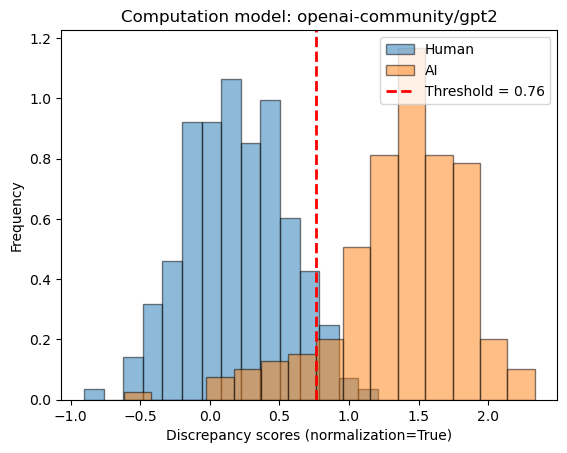

In [ ]:
roc_curves(fpr,tpr)

## References
[1] E. Mitchell, C. Lin, A. Bosselut, and C. D. Manning, "DetectGPT: Zero-Shot Machine-Generated Text Detection using Probability Curvature" *arXiv preprint*, 2023. Available at: [arXiv:2301.11305](https://arxiv.org/abs/2301.11305)